## Stroke prediction

<img src="image/stroke.jpg" width="600" height="400" align=left>



The public dataset is acquired from the Kaggle called [Stroke Prediction Dataset](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset). However, the owner of the dataset has specified that the source is classified therefore there is no way to verify where and how this dataset was collected. Therefore, as a disclaimer, the following work should be considered as a toy exercise.

### Attribute Information

1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

### EXPLORATORY DATA ANALYSIS

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import os
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [117]:
path = os.getcwd()
data = pd.read_csv(path+"/data/healthcare-dataset-stroke-data.csv")

In [118]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [119]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


First, let check if we have missing values. It seems that we do, as you can see in the BMI.

In [121]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [122]:
data.replace(to_replace=np.nan, value=data.bmi.mean(), inplace=True)

Now let's check if there is anymore null values and there is none (no pun intended). Great, looks good.

In [123]:
data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Stroke risk factors

So let's dive deep into the factors that could potentially increases the chances of getting a stroke. According to [Mayo Clinic's website](https://www.mayoclinic.org/diseases-conditions/stroke/symptoms-causes/syc-20350113) and [NHLBI](https://www.nhlbi.nih.gov/health-topics/stroke), the risk factors include:

- High blood pressure (hypertension)
- Unhealthy diet/lifestyle habits
- Heart diseases
- Smoking
- Diabetes
- High cholesterol
- Age
- Race
- Gender
- Family history
- Work or home environment
- Physical inactivity
- Hormones

Based on those factors, we will try to dissect relevant information for the following analysis. Therefore we need to inquire the following questions:

1. The most obvious one would be describing the relation between the above mentioned risk factors with potential occurence of a stroke. Some of the risk factors are part of the features in our data.
2. Can we describe the relation of potential stroke attack with other health data such as BMI, glucose level,etc.

So, let's begin by getting to know our participants.

### Gender count

In [124]:
fig = px.pie(data,names='gender')
fig.update_layout(title='<b>Proportion Of Gender<b>')
fig.show()

### Age

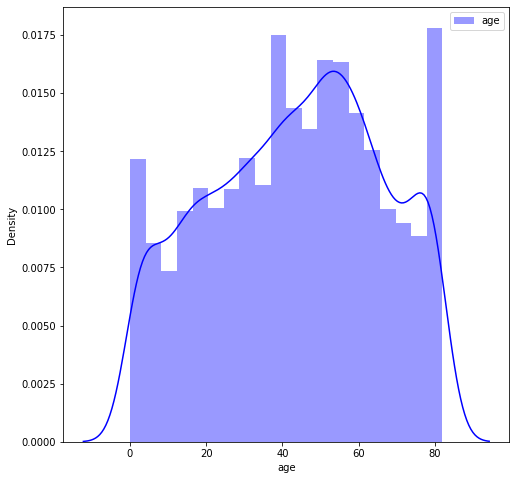

In [125]:
fig = plt.figure(figsize=(8,8))
sns.distplot(data.age, color="blue", label="age", kde= True)
plt.legend()
plt.show()

As we can see, there are slightly more female participants in our data. We also have a small population who wished not to identify their gender.

### Employment types

Next, we want to know what is the working environment as this is considered to be one of the risk factors and it might provide some relation to the illness.

In [126]:
fig = px.pie(data,names='work_type')
fig.update_layout(title='<b>Proportion Of Work Type<b>')
fig.show()

It seems that a huge chunk of the survey participants are working in the private sector. However, the data does not specify what kind of industry that these participants are in. This is important because different work environments may provide some clues as to which profession that could have higher potential risks of stroke. Also, it is suprising to see children are included in the data making up 13.4% of the population. We may need some further clarification from the data's owner and also medical experts in regards to such inclusion.

### Residence types

The data shows that we have evenly split between residents who lived in both urban and rural areas.

In [127]:
fig = px.pie(data,names='Residence_type')
fig.update_layout(title='<b>Proportion Of Residence Type<b>')
fig.show()

### Smoking status
We need to investigate the number of participants who were former smokers, current smokers or none smokers. The unknown group poses a bit of problem in our anaylsis because their status is undetermined.

Based on the inspection below, we have more non-smokers in the survey with 37%.

In [128]:
fig = px.pie(data,names='smoking_status')
fig.update_layout(title='<b>Proportion of smoking status<b>')
fig.show()

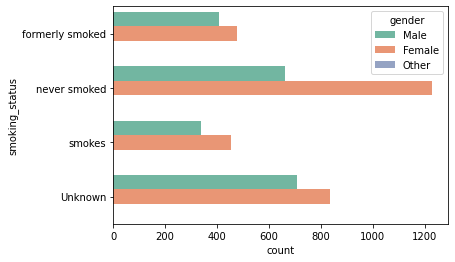

In [129]:
ax2 = sns.countplot(y=data.smoking_status, hue=data.gender, data=data, palette="Set2")
plt.show()

### Smoking status based on residence
We also want to know the residential status of the participants who are actually smokers and non-smokers.

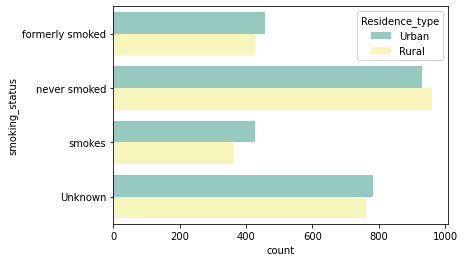

In [130]:
ax2 = sns.countplot(y=data.smoking_status, hue=data.Residence_type, data=data, palette="Set3")
plt.show()

### Hypertension

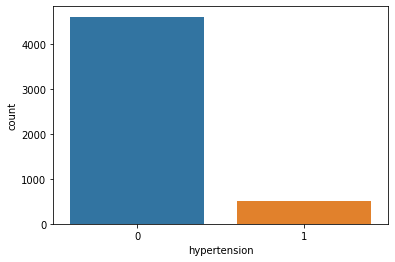

In [131]:
ax = sns.countplot(data=data, x="hypertension")
plt.show()

### Heart disease

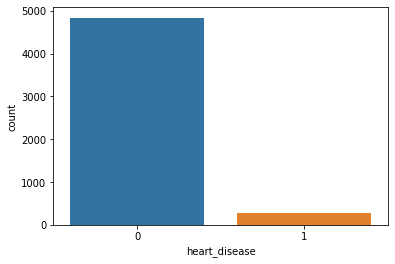

In [132]:
ax = sns.countplot(data=data, x="heart_disease")
plt.show()

### Stroke

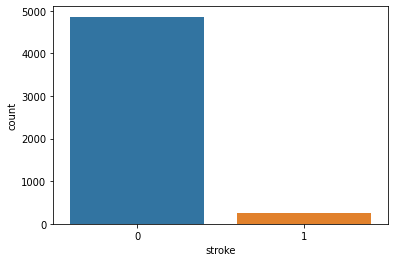

In [133]:
ax = sns.countplot(data=data, x="stroke")
plt.show()

From each of the categorical features above, we can clearly see there is an imbalance in our dataset. One of the common ways to rectify the imbalance problem by synthesizing new examples in the minority classes using <b>SMOTE</b>. But before we proceed to feature selection and modeling, we need to conduct a few more analysis in order to acquire a better understanding of important features that will be used in our stroke prediction task.

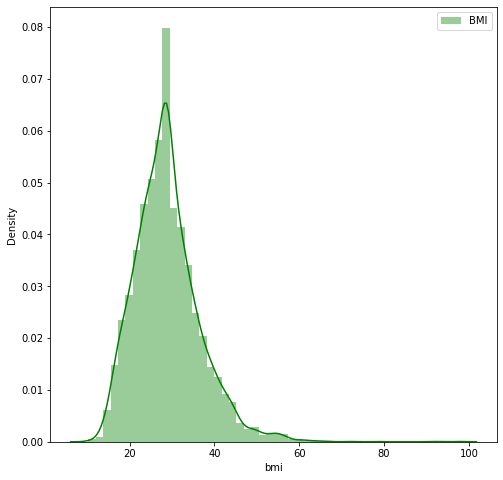

In [134]:
fig = plt.figure(figsize=(8,8))
sns.distplot(data.bmi, color="green", label="BMI", kde= True)
plt.legend()
plt.show()

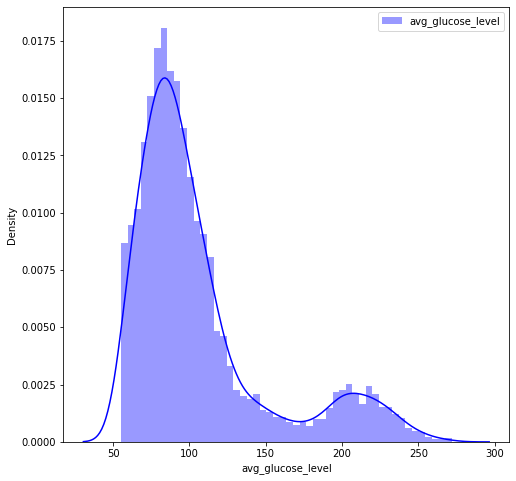

In [135]:
fig = plt.figure(figsize=(8,8))
sns.distplot(data.avg_glucose_level, color="blue", label="avg_glucose_level", kde= True)
plt.legend()
plt.show()

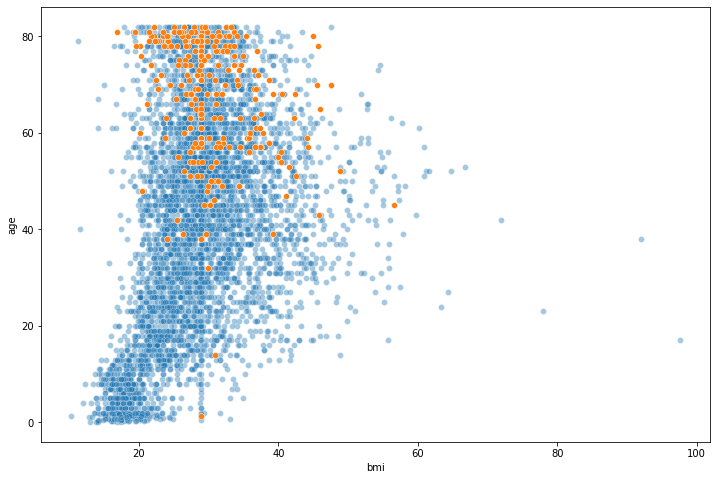

In [136]:
# Age vs BMI with hue = stroke
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x="bmi", y="age", alpha=0.4, data=data[data['stroke'] == 0])
sns.scatterplot(x="bmi", y="age", alpha=1, data=data[data['stroke'] == 1], ax=ax)
plt.show()

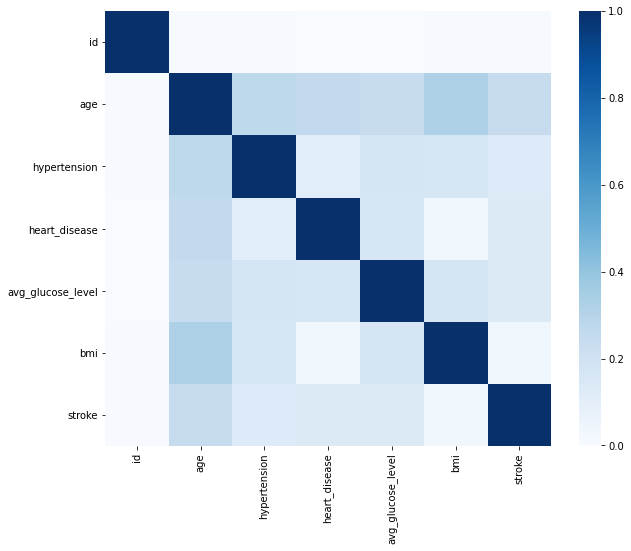

In [137]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(),cmap="Blues");

### Rectifying class imbalance problem with SMOTE

We need to convert categorical features to numerical

In [138]:

gender_convert = {'Male': 0, 'Female': 1, 'Other': 2}
marriage_convert = {'No': 0, 'Yes': 1}
work_type_convert = {'children': 0, 'Never_worked': 1, 'Govt_job': 2, 'Private': 3, 'Self-employed': 4}
residence_type_convert = {'Rural': 0, 'Urban': 1}
smoking_status_convert = {'Unknown': 0, 'never smoked': 1, 'formerly smoked':2, 'smokes': 3}

data['gender'] = data['gender'].map(gender_convert)
data['ever_married'] = data['ever_married'].map(marriage_convert)
data['work_type'] = data['work_type'].map(work_type_convert)
data['Residence_type'] = data['Residence_type'].map(residence_type_convert)
data['smoking_status'] = data['smoking_status'].map(smoking_status_convert)

In [139]:
X = data.drop(columns=['id', 'stroke'])
y = data['stroke']

In [140]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 2) 
X, y = sm.fit_resample(X, y) 

### Model selection and prediction

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [144]:
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier())
pipeline.fit(X_train, y_train)
prediction = pipeline.predict(X_test)

print(f"Accuracy Score : {round(accuracy_score(y_test, prediction) * 100, 2)}%")


Accuracy Score : 93.76%


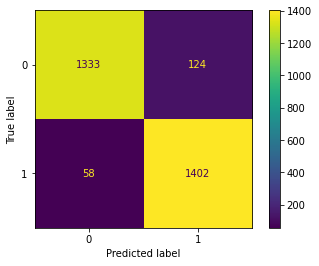

In [146]:
plot_confusion_matrix(pipeline, X_test, y_test)
plt.grid(False)
plt.show()